In [1]:
import os

import numpy as np

import torch
import torchvision
from torchvision.io import read_image

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import ignite

from piq import BRISQUELoss, TVLoss, brisque, ssim, psnr

import cv2

import matplotlib.pyplot as plt

from utils import loss_history, plot_history

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dense, InputLayer, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Subtract, Concatenate, Add
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
#from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [40]:
path_img = './data/RealSR(V3)/canon/train/2'
images_lr = []
images_hr = []
size_lr = (400,700)
size_hr = (800,1400)

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        img = image.img_to_array(image.load_img(os.path.join(path_img, filename),
                                 target_size=size_lr,
                                 keep_aspect_ratio=True)).astype('float32')
        images_lr.append(img/255.)
    else:
        img = image.img_to_array(image.load_img(os.path.join(path_img, filename),
                                 target_size=size_hr,
                                 keep_aspect_ratio=True)).astype('float32')
        images_hr.append(img/255.)

path_img = './data/RealSR(V3)/canon/test/2'
images_lr_test = []
images_hr_test = []

for filename in os.listdir(path_img):
    if filename.find('LR')>0:
        img = image.img_to_array(image.load_img(os.path.join(path_img, filename),
                                 target_size=size_lr,
                                 keep_aspect_ratio=True)).astype('float32')
        images_lr_test.append(img/255.)
    else:
        img = image.img_to_array(image.load_img(os.path.join(path_img, filename),
                                 target_size=size_hr,
                                 keep_aspect_ratio=True)).astype('float32')
        images_hr_test.append(img/255.)

In [41]:
images_lr_downscales = []
scale = 2
for image_ in images_lr:
    new_size = np.array([image_.shape[0]/scale, image_.shape[1]/scale])
    image_downscale = tf.image.resize(image_, new_size)
    images_lr_downscales.append(image_downscale)
    
images_lr_downscales_test = []
scale = 2
for image_ in images_lr_test:
    new_size = np.array([image_.shape[0]/scale, image_.shape[1]/scale])
    image_downscale = tf.image.resize(image_, new_size)
    images_lr_downscales_test.append(image_downscale)

In [48]:
images_lr = np.array(images_lr)
images_hr = np.array(images_hr)
images_lr_test = np.array(images_lr_test)
images_hr_test = np.array(images_hr_test)
images_lr_downscales = np.array(images_lr_downscales)
images_lr_downscales_test = np.array(images_lr_downscales_test)

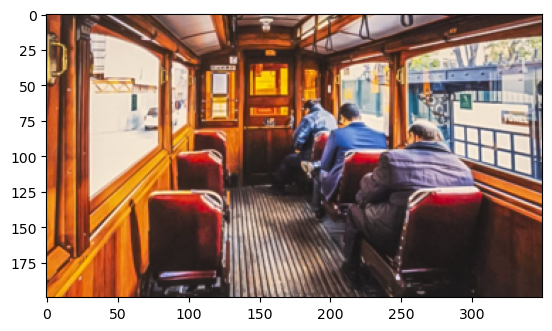

In [49]:
plt.imshow(images_lr_downscales[0])

In [56]:
def lrdown2lr(scale=2, img_shape=(None,None,3)):
    
    input = Input(img_shape)
    n_blocks = 8
    
    x = UpSampling2D(size=(scale,scale))(input)
    
    x = Conv2D(128, kernel_size=(3,3),  #bias_initializer='glorot_normal',
                                        #kernel_initializer='glorot_normal',
                                        padding='same')(x)
    x = Activation('gelu')(x)
    for i in range(n_blocks):
        xx = Conv2D(128, kernel_size=(3,3),  #bias_initializer='glorot_normal', 
                                             #kernel_initializer='glorot_normal',
                                             padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3),  #bias_initializer='glorot_normal', 
                                      #kernel_initializer='glorot_normal',
                                      padding='same')(x)
    #out = Subtract()([input, x])
    out = x

    model = Model(input, out)
    model.summary()
    
    return model    
    

In [57]:
def ssim_l2(y_true, y_pred):
    ssim = 1. - tf.image.ssim(y_true, y_pred, max_val=1.)
    l2 = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return ssim + l2

In [58]:
model = lrdown2lr()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5)

model.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = model.fit(images_lr_downscales, images_lr,
                    epochs=40,
                    callbacks=[reduce_lr],
                    #validation_split=0.2,
                    validation_data=(images_lr_downscales_test, images_lr_test),
                    batch_size=1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, None, None,   0          ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, None, None,   3584        ['up_sampling2d_3[0][0]']        
                                128)                                                        

                                                                                                  
 add_53 (Add)                   (None, None, None,   0           ['add_52[0][0]',                 
                                128)                              'activation_57[0][0]']          
                                                                                                  
 conv2d_61 (Conv2D)             (None, None, None,   147584      ['add_53[0][0]']                 
                                128)                                                              
                                                                                                  
 batch_normalization_54 (BatchN  (None, None, None,   512        ['conv2d_61[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 activatio

In [59]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()

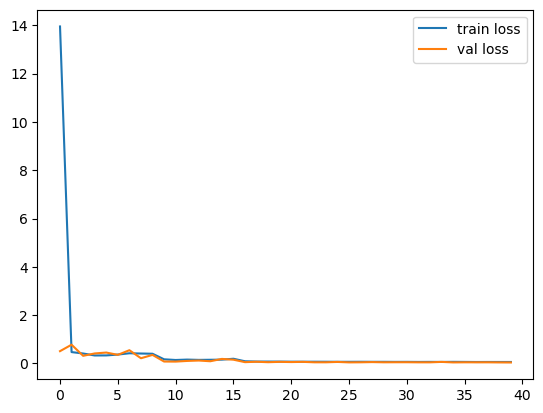

In [60]:
plot_history(history)

In [68]:
pred = model((images_lr[0])[None,:])

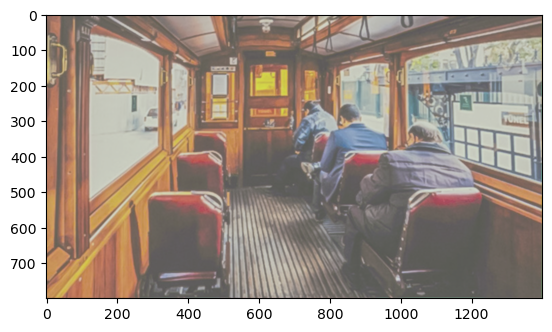

In [69]:
img = image.array_to_img(pred[0])
plt.imshow(img)
image.save_img('out_upscaled_tf.png',img)

In [ ]:
def plot_result(image_true, image_lr, image_reconstructed, max_value=1.):
    plt.subplots(1,3, figsize=(15, 15))
    plt.subplot(1,3,1)
    plt.imshow(image_true)
    plt.title(f'Ground True')
    plt.subplot(1,3,2)
    plt.imshow(image_lr)
    plt.title(f'LR, PSNR={tf.image.psnr(image_true, image_lr, max_val=max_value)}')
    plt.subplot(1,3,3)
    plt.imshow(image_reconstructed)
    plt.title(f'Reconstructed, PSNR={tf.image.psnr(image_true, image_reconstructed, max_val=max_value)}')

# deblur

In [ ]:
def nn_deblur(img_size=(None, None,3)):
    
    input = Input(img_size)
    
    x0 = Conv2D(3, kernel_size=(1,1),  #bias_initializer='glorot_normal',
                                        #kernel_initializer='glorot_normal',
                                        padding='same')(input)
    x = Conv2D(3, kernel_size=(3,3),  #bias_initializer='glorot_normal',
                                        #kernel_initializer='glorot_normal',
                                        padding='same')(x0)
    x = Conv2D(3, kernel_size=(5,5),  #bias_initializer='glorot_normal',
                                        #kernel_initializer='glorot_normal',
                                        padding='same')(x)
    x_add = Conv2D(3, kernel_size=(1,1),  #bias_initializer='glorot_normal',
                                        #kernel_initializer='glorot_normal',
                                        padding='same')(x0)
    x = Add()([x0, x_add])
    out = Activation('gelu')(x)
    
    model = Model(input, out)
    model.summary()
    
    return model

In [ ]:
brisque_loss = BRISQUELoss(data_range=1.)


In [73]:
brisque(pred)

AssertionError: Expected torch.Tensor, got <class 'tensorflow.python.framework.ops.EagerTensor'>

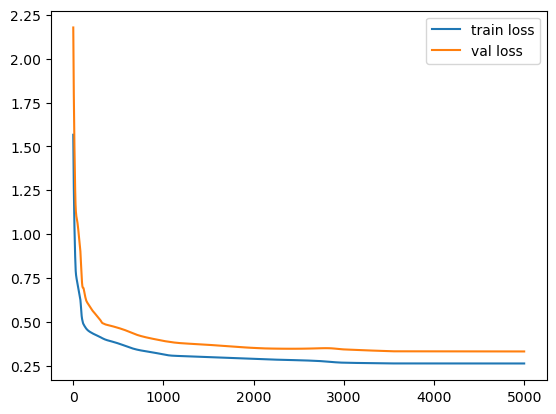

In [83]:
plot_history(history)

tensor(0.8423) tensor(0.9263)


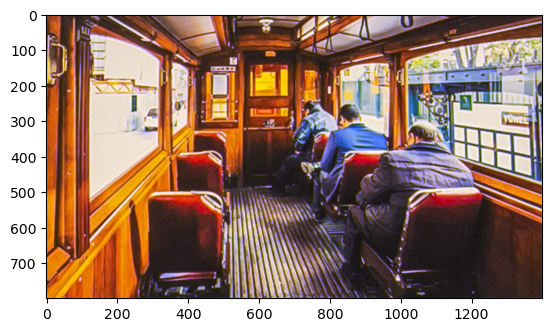

In [84]:
#test = images_lr[0]
test = read_image('out_before.png')
test = test[None, :]
model_deblur.eval()
with torch.no_grad():
    preds = model_deblur(test).type(torch.LongTensor)
img = preds[0].permute(1,2,0).detach()
to_save = (preds[0])/255.
torchvision.utils.save_image(to_save, 'out.png')
plt.imshow(img)

ref = images_hr[0]
ref = ref[None, :]
ssim_after = ssim(preds, ref, data_range=255)
ssim_before = ssim(test, ref, data_range=255)
print(ssim_after, ssim_before)

In [439]:
torch.save(model_deblur, 'ssim09282_1000epochs')
torch.save({
            'epoch': 1000,
            'model_state_dict': model_deblur.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion_deblur
            }, 'torch_ssim09282_1000epochs')

In [422]:
images_lr[0]

tensor([[[0.4980, 0.5686, 0.6078,  ..., 0.1961, 0.2039, 0.2078],
         [0.4941, 0.5529, 0.5804,  ..., 0.2157, 0.2196, 0.2235],
         [0.5059, 0.5529, 0.5725,  ..., 0.2706, 0.2824, 0.2941],
         ...,
         [0.9490, 0.9608, 0.9412,  ..., 0.2471, 0.2431, 0.2353],
         [0.9608, 0.9490, 0.9255,  ..., 0.2431, 0.2431, 0.2353],
         [0.9412, 0.9137, 0.9020,  ..., 0.2431, 0.2431, 0.2431]],

        [[0.2549, 0.2941, 0.3020,  ..., 0.1529, 0.1529, 0.1529],
         [0.2353, 0.2706, 0.2784,  ..., 0.1529, 0.1490, 0.1412],
         [0.2235, 0.2510, 0.2627,  ..., 0.1686, 0.1686, 0.1725],
         ...,
         [0.5490, 0.5686, 0.5490,  ..., 0.1608, 0.1569, 0.1490],
         [0.5608, 0.5529, 0.5333,  ..., 0.1608, 0.1569, 0.1529],
         [0.5333, 0.5137, 0.5020,  ..., 0.1608, 0.1608, 0.1647]],

        [[0.1451, 0.1725, 0.1843,  ..., 0.1412, 0.1451, 0.1529],
         [0.1569, 0.1882, 0.1922,  ..., 0.1294, 0.1333, 0.1333],
         [0.1647, 0.1922, 0.1961,  ..., 0.1373, 0.1451, 0.

In [76]:
images_lr[0][0].numpy().shape

(400, 700)

In [79]:
lr = images_lr_downscales[0][0].numpy()
hr = images_hr[0][0].numpy()

gy, gx = np.gradient(lr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

gy, gx = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2)
print(np.average(gnorm))

21.01626905868889
10.95381203369981


In [88]:
lr = images_lr_downscales[0].type(torch.FloatTensor)
hr = images_hr[0].type(torch.FloatTensor)

gy, gx, gc = torch.gradient(lr)
gnorm = torch.sqrt(gx**2 + gy**2 + gc**2)
print(torch.mean(gnorm))

gy, gx, gc = np.gradient(hr)
gnorm = np.sqrt(gx**2 + gy**2 + gc**2)
print(np.average(gnorm))

tensor(40.4811)
34.710903


In [180]:
trainer.loss.grad

In [268]:
def dft_amp(img):
    fft_im = torch.fft.rfft( img, signal_ndim=2, onesided=False )
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    return torch.sqrt(fft_amp)

dft_amp(images_lr[0])

TypeError: fft_rfft() got an unexpected keyword argument 'signal_ndim'

In [276]:
torch.fft.rfft(images_hr[0]).shape

torch.Size([3, 800, 701])

In [292]:
def tensor2freq(x):
    # crop image patches
    patch_factor = 1
    _, _, h, w = x.shape
    assert h % patch_factor == 0 and w % patch_factor == 0, (
        'Patch factor should be divisible by image height and width')
    patch_list = []
    patch_h = h // patch_factor
    patch_w = w // patch_factor
    for i in range(patch_factor):
        for j in range(patch_factor):
            patch_list.append(x[:, :, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w])

        # stack to patch tensor
    y = torch.stack(patch_list, 1)

    # perform 2D DFT (real-to-complex, orthonormalization)
    freq = torch.fft.fft2(y, norm='ortho')
    freq = torch.stack([freq.real, freq.imag], -1)
    
    return freq.mean()


In [293]:
test = images_lr[0]
test = test[None, :]
tensor2freq(test)

tensor(0.0721)

In [4]:
def getSharpness(images):
    sharpness_vals = []
    derivative_imgs = []
    for img in images:
        derivative = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
        derivative_imgs.append(derivative)
        sharpness_vals.append(cv2.norm(derivative))
    return derivative_imgs, sharpness_vals

In [19]:
images_np = np.array(images_lr[0])
a, b = getSharpness(images_np)

In [42]:
b

[924742.4838478008, 804595.2767317243, 728193.959805353]

In [36]:
a

[array([[   0.,  908.,  760., ...,  150.,  136.,    0.],
        [   0.,  842.,  656., ...,  227.,  185.,    0.],
        [   0.,  751.,  504., ...,  409.,  316.,    0.],
        ...,
        [   0., -190., -472., ...,  -66.,  -76.,    0.],
        [   0., -343., -505., ...,  -78.,  -74.,    0.],
        [   0., -388., -478., ...,  -80.,  -66.,    0.]]),
 array([[   0.,  346.,   94., ...,  -16.,  -46.,    0.],
        [   0.,  362.,  129., ...,   20.,   -4.,    0.],
        [   0.,  410.,  196., ...,  150.,  141.,    0.],
        ...,
        [   0., -124., -482., ...,  -58.,  -70.,    0.],
        [   0., -283., -510., ...,  -72.,  -65.,    0.],
        [   0., -330., -486., ...,  -74.,  -54.,    0.]]),
 array([[   0.,  276.,   24., ...,   74.,  100.,    0.],
        [   0.,  278.,   15., ...,  134.,  152.,    0.],
        [   0.,  309.,   18., ...,  307.,  312.,    0.],
        ...,
        [   0., -101., -523., ...,  -69.,  -76.,    0.],
        [   0., -308., -626., ...,  -87.,  -9

In [18]:
torch_sobel = Sobel()

In [38]:
images_tensor = torch.FloatTensor(np.array(images_lr[:1]))
im_gr = torchvision.transforms.Grayscale()(images_tensor)
print(im_gr.shape)
derivs = torch_sobel(im_gr)
derivs

torch.Size([1, 1, 400, 700])


tensor([[[[124.3786,  65.1107,  70.5449,  ...,  55.6721,  64.9517,  68.5075],
          [110.8581,  22.6103,  26.8387,  ..., 168.0509, 195.4942, 243.8969],
          [119.5695,  33.0675,  40.2347,  ..., 320.4005, 336.0049, 361.7405],
          ...,
          [ 73.6868,  53.7021, 105.2892,  ...,   0.8454,   4.0844,  14.1444],
          [  1.1179,  93.7471, 108.4399,  ...,   2.1554,   7.5163,  18.8298],
          [ 91.5316, 105.1587,  86.2123,  ...,   9.7318,  11.0912,  16.1775]]]])

In [43]:
torch.linalg.norm(derivs)

tensor(165562.7188)

In [70]:
loss_sobel(images_tensor, None)

tensor(165562.7188, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


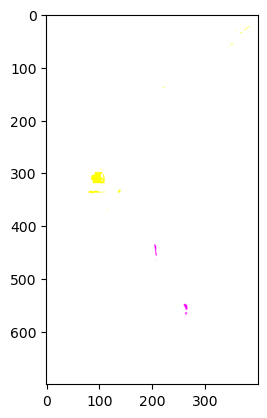

In [163]:
images_tensor = torch.FloatTensor(np.array(images_lr[0]))
blur = torchvision.transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.))(images_tensor)
plt.imshow(blur.T)
torchvision.utils.save_image(blur, 'test1_blur.png')

In [ ]:
class Sobel(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=0, bias=False)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        G = torch.cat([Gx.unsqueeze(0), Gy.unsqueeze(0)], 0)
        G = G.unsqueeze(1)
        self.filter.weight = nn.Parameter(G, requires_grad=True)

    def forward(self, img):
        x = self.filter(img)
        x = torch.mul(x, x)
        x = torch.sum(x, dim=1, keepdim=True)
        x = torch.sqrt(x)
        return x
    
def loss_sobel(y_pred, y_true):
    torch_sobel = Sobel()
    grayscale = torchvision.transforms.Grayscale()(y_pred)
    out = torch.linalg.norm(torch_sobel(grayscale))
    print(out)
    return 1/out    

In [262]:
ignite.============

[tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126, 141, 148,  ...,  55,  56,  57],
          [129, 141, 146,  ...,  69,  72,  75],
          ...,
          [242, 245, 240,  ...,  63,  62,  60],
          [245, 242, 236,  ...,  62,  62,  60],
          [240, 233, 230,  ...,  62,  62,  62]],

         [[ 65,  75,  77,  ...,  39,  39,  39],
          [ 60,  69,  71,  ...,  39,  38,  36],
          [ 57,  64,  67,  ...,  43,  43,  44],
          ...,
          [140, 145, 140,  ...,  41,  40,  38],
          [143, 141, 136,  ...,  41,  40,  39],
          [136, 131, 128,  ...,  41,  41,  42]],

         [[ 37,  44,  47,  ...,  36,  37,  39],
          [ 40,  48,  49,  ...,  33,  34,  34],
          [ 42,  49,  50,  ...,  35,  37,  40],
          ...,
          [ 32,  40,  36,  ...,  36,  34,  34],
          [ 39,  38,  33,  ...,  36,  35,  33],
          [ 39,  31,  27,  ...,  37,  36,  36]]]], dtype=torch.uint8), tensor([[[[127, 145, 155,  ...,  50,  52,  53],
          [126,